# Experiment: Error vs inverse temperature (β-scaling)

Experiment (Fig. 2a): benchmark the trace-distance sampling error versus inverse temperature β under different step scalings N=O(β^k).

In [2]:
import numpy as np
from scipy.linalg import expm

import quairkit as qkit
from quairkit.database import *
from quairkit.database import completely_mixed_computational, eye, x, y, z
from quairkit.qinfo import *

qkit.set_dtype('complex128')

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from gibbs import *

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "font.family": "STIXGeneral",
    "mathtext.fontset": "cm",
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "lines.linewidth": 1.4,
    "lines.markersize": 4.5,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "xtick.major.size": 3.0,
    "ytick.major.size": 3.0,
    "axes.labelpad": 2,
})

## Experimental setting

In [5]:
n, hamiltonian = build_2d_heisenberg(3, 3, Jxy=0.05, Jz=0.04)
lb, si, sites = hamiltonian.decompose_with_sites()
xi = sum([abs(coef) for coef in lb])

In [6]:
list_beta = np.arange(1.0, 10.1, 1.0).tolist()

error_level = 3
error = 10 ** (-error_level)

list_N = [lambda beta: int(np.ceil((xi ** 2) * (beta ** 2) / (error ** (2 / 3)))),
          lambda beta: int(np.ceil((xi ** 2) * (beta ** 1.5) / (error ** (2 / 3)))),
          lambda beta: int(np.ceil((xi ** 2) * (beta ** 2.5) / (error ** (2 / 3))))]

In [7]:
num_sample = 100

In [8]:
init_state = completely_mixed_computational(n)

## Compute data

In [ ]:
import os

os.makedirs("data", exist_ok=True)

save_dir = "data"
save_tag = "error_beta"

# ------------------------
# Run algorithm1 and collect max error directly from sample_error
# ------------------------
list_list_state = []
list_list_coef  = []
list_list_error = []
list_list_prob  = []

# N-scaling ： max(sample_error)
K = len(list_N)  # 3
max_errors_by_scaling = [[] for _ in range(K)]

for beta in list_beta:
    for i, N_func in enumerate(list_N):
        qkit.set_seed(20260107)
        
        num_step = int(N_func(beta))

        list_state, sample_coef, sample_error, list_prob = algorithm1(
            n=n,
            beta=beta,
            hamiltonian=hamiltonian,
            error=error,
            num_sample=num_sample,
            num_step=num_step,
            init_state=init_state,
            save_dir="data",
            save_tag="error_beta",
            save_state=False,
            save_compressed=True,
        )


        beta_tag = f"{float(beta):.6g}"
        err_tag  = f"{float(error):.6g}"
        path = os.path.join(
            save_dir,
            f"{save_tag}_b{beta_tag}_e{err_tag}_sample{int(num_sample)}_step{int(num_step)}.npz",
        )

        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing cached file: {path}")

        data = np.load(path, allow_pickle=True)
        sample_error = data["sample_error"]
        max_errors_by_scaling[i].append(np.max(sample_error))


In [ ]:
np.savez_compressed("data/error_vs_beta.npz",
                    list_beta=np.array(list_beta),
                    max_errors_by_scaling=np.array(max_errors_by_scaling))

We also provide saved data to save computation time.

In [ ]:
# list_beta, max_errors_by_scaling = np.load("data/error_vs_beta.npz")['list_beta'], np.load("data/error_vs_beta.npz")['max_errors_by_scaling']

## Plot

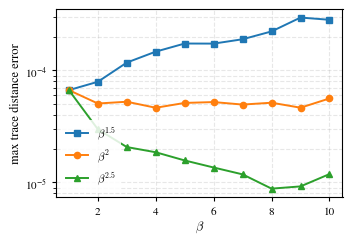

In [12]:
LEG_KW = dict(frameon=True, facecolor="white", edgecolor="none", framealpha=0.85)

K = len(max_errors_by_scaling)
default_labels  = [r'$\beta^2$', r'$\beta^{1.5}$', r'$\beta^{2.5}$']
default_markers = ['o', 's', '^', 'D', 'v', 'P']
labels  = default_labels[:K] + [f"curve{i}" for i in range(len(default_labels), K)]
markers = default_markers

# legend order (top->bottom) as in your final figure: beta^1.5, beta^2, beta^2.5
order = [1, 0, 2]  # adjust if your K/order differs

fig, ax = plt.subplots(figsize=(3.375, 2.3))

for i in order:
    if i >= K:
        continue
    ax.plot(list_beta, max_errors_by_scaling[i],
            marker=markers[i % len(markers)],
            label=labels[i])

ax.set_yscale("log")
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('max trace distance error')
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.legend(loc="lower left", **LEG_KW)

fig.tight_layout(pad=0.2)
plt.show()


---

In [13]:
qkit.print_info()


---------VERSION---------
quairkit: 0.5.0
torch: 2.9.1
numpy: 2.2.6
scipy: 1.15.2
matplotlib: 3.10.8
---------SYSTEM---------
Python version: 3.10.19
OS: Darwin
OS version: Darwin Kernel Version 23.5.0: Wed May  1 20:14:38 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T6020
---------DEVICE---------
CPU: Apple M2 Pro
